In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, models, losses, optimizers
from sklearn.preprocessing import StandardScaler
import numpy as np

In [2]:
df = pd.read_csv('./data/clean/df_total.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
df = df.resample('YE').mean()
df = df.reset_index().sort_values(by='DATE')
df = df[['DATE', 'PRENEI_Q', 'PRELIQ_Q', 'T_Q', 'FF_Q', 'Q_Q',
       'DLI_Q', 'SSI_Q', 'HU_Q', 'EVAP_Q', 'ETP_Q', 'PE_Q', 'SWI_Q',
       'DRAINC_Q', 'RUNC_Q', 'RESR_NEIGE_Q', 'RESR_NEIGE6_Q', 'HTEURNEIGE_Q',
       'HTEURNEIGE6_Q', 'HTEURNEIGEX_Q', 'SNOW_FRAC_Q', 'ECOULEMENT_Q',
       'WG_RACINE_Q', 'WGI_RACINE_Q', 'TINF_H_Q', 'TSUP_H_Q']]

<Axes: >

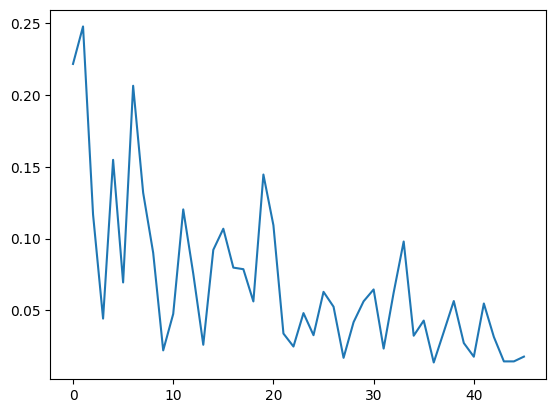

In [3]:
df['HTEURNEIGE_Q'].plot()

In [4]:
df_trend = df[['DATE','HTEURNEIGE_Q']]

In [5]:
df_trend = df_trend.set_index("DATE")

In [6]:
df_trend = df_trend.resample("D").interpolate(method="linear")

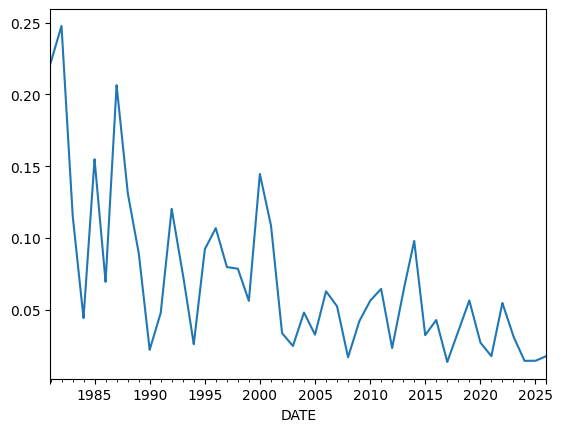

In [8]:
df_trend['HTEURNEIGE_Q'].plot();

In [12]:
df_trend

HTEURNEIGE_Q
DATE                    
1980-12-31      0.221585
1981-01-01      0.221656
1981-01-02      0.221728
1981-01-03      0.221799
1981-01-04      0.221871
...                  ...
2025-12-27      0.017695
2025-12-28      0.017704
2025-12-29      0.017713
2025-12-30      0.017722
2025-12-31      0.017731

[16437 rows x 1 columns]

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [42]:
idx = df_trend.index  # DatetimeIndex
y = df_trend['HTEURNEIGE_Q'].to_numpy()
X = idx.view('i8').reshape(-1, 1)

y_log = np.log(y)

# degree = 4

model = LinearRegression()
model.fit(X, y_log)

LinearRegression()

In [43]:
y_pred_train = np.exp(model.predict(X))

In [56]:
step = idx[1] - idx[0]            # e.g., Timedelta('1D')
future_dates = pd.date_range(start=idx[-1] + step, periods=3650, freq=step)

In [57]:
future_X = future_dates.view('i8').reshape(-1, 1)
trend_forecast = np.exp(model.predict(future_X))

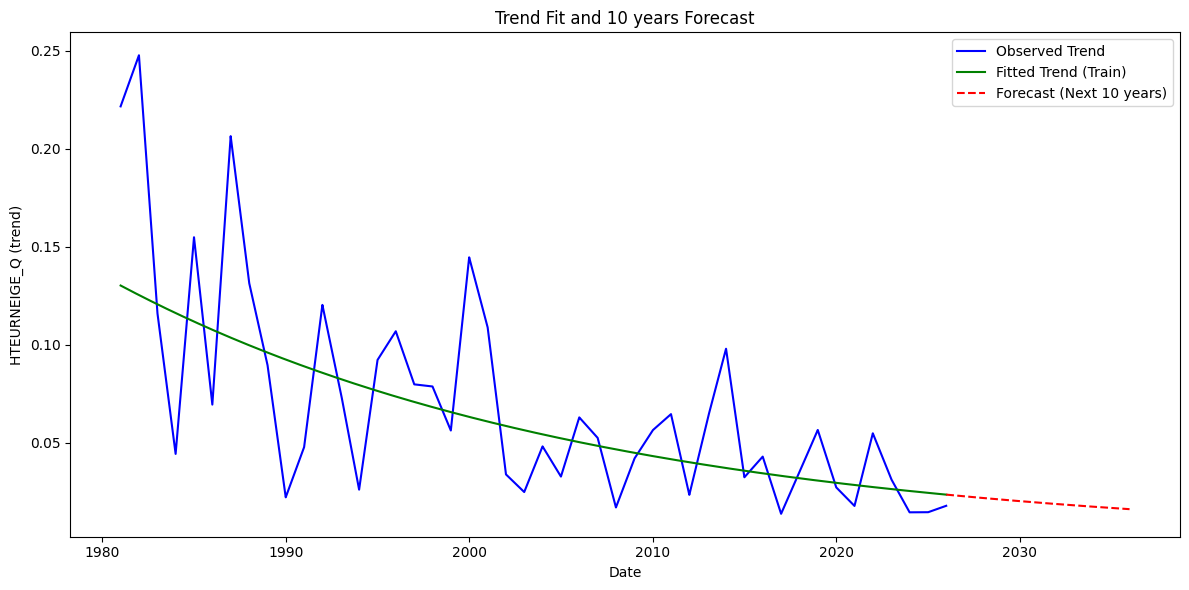

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(idx, y, label='Observed Trend', color='blue')
plt.plot(idx, y_pred_train, label='Fitted Trend (Train)', color='green')
plt.plot(future_dates, trend_forecast, label='Forecast (Next 10 years)', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('HTEURNEIGE_Q (trend)')
plt.title('Trend Fit and 10 years Forecast')
plt.legend()
plt.tight_layout()
plt.show()

In [270]:
def transform_to_supervised(df, datetime_col, feature_cols, target_col, n_past=3, n_future=1):

    df = df.copy()
    df.sort_values(by=datetime_col, inplace=True)
    df.reset_index(drop=True, inplace=True)

    supervised = pd.DataFrame()

    for col in feature_cols:
        for i in range(n_past, 0, -1):
            supervised[f'{col}(t-{i})'] = df[col].shift(i)

    for i in range(0, n_future):
        supervised[f'{target_col}(t+{i})'] = df[target_col].shift(-i)

    supervised.dropna(inplace=True)

    return supervised

In [272]:
df_supervised = transform_to_supervised(df_trend, 'DATE', ['HTEURNEIGE_Q'], 'HTEURNEIGE_Q', n_past=365*20, n_future=365*5)

C:\Users\dmitrii.druzhbin\AppData\Local\Temp\ipykernel_12816\3562563507.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  supervised[f'{col}(t-{i})'] = df[col].shift(i)
C:\Users\dmitrii.druzhbin\AppData\Local\Temp\ipykernel_12816\3562563507.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  supervised[f'{col}(t-{i})'] = df[col].shift(i)
C:\Users\dmitrii.druzhbin\AppData\Local\Temp\ipykernel_12816\3562563507.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

In [273]:
X = df_supervised.iloc[:,:-365*5].copy()
y = df_supervised.iloc[:,-365*5:].copy()

In [274]:
X_train, X_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):]
y_train, y_test = y[:int(len(X)*0.8)], y[int(len(X)*0.8):]

In [275]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

# y_train_scaled = scaler_y.fit_transform(pd.DataFrame(y_train))
# y_test_scaled = scaler_y.transform(pd.DataFrame(y_test))
y_train_scaled = pd.DataFrame(y_train)
y_test_scaled = pd.DataFrame(y_test)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.svm import SVR
from sklearn.metrics import root_mean_squared_error

# param_grid = {
#     'n_estimators': [50, 100],
#     'max_depth': [None, 5, 10, 20],
#     'min_samples_split': [2, 5, 10, 15],
#     'min_samples_leaf': [1, 2, 4, 5],
#     'bootstrap': [True, False]
# }

# param_grid = {
#     'n_estimators': [50, 100],
#     'max_depth': [2, 3, 6, 9],
#     'learning_rate': [0.01, 0.1],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
# }

# param_grid = {
#     'kernel': ['rbf'],  # or 'linear', 'poly', 'sigmoid'
#     'C': [0.1, 1, 10, 100],  # Regularization strength
#     'epsilon': [0.01, 0.1, 0.2],  # Tube size for no penalty
#     'gamma': ['scale', 0.1, 0.01, 0.001]  # Kernel coefficient
# }


model_rf = RandomForestRegressor(random_state=42)
model_xgb = XGBRegressor(random_state=42, n_jobs=-1)
model_svm = SVR()

tscv = TimeSeriesSplit(n_splits=5)

# grid_search = GridSearchCV(
#     estimator=model_svm,
#     param_grid=param_grid,
#     cv=tscv,
#     scoring='neg_mean_squared_error',
#     verbose=2,
#     n_jobs=-1
# )


# grid_search.fit(X_train_scaled, y_train_scaled)

# best_model = grid_search.best_estimator_

best_model = model_xgb.fit(X_train_scaled, y_train_scaled)
# best_model = model_xgb.fit(X_train_scaled, y_train_scaled)

yhat = best_model.predict(X_test_scaled)
yhat_train = best_model.predict(X_train_scaled)


In [ ]:
print(root_mean_squared_error(y_test_scaled, yhat))

plt.plot(yhat_train, label='Predicted mean')
# plt.fill_between(range(len(mu_pred_test)),
#                  mu_pred_test - 1.96 * sigma_test,
#                  mu_pred_test + 1.96 * sigma_test,
#                  alpha=0.3, label='95% CI')
plt.plot(y_train_scaled.reset_index(drop=True), label='True', alpha=0.6)
plt.legend()
plt.title("Forecast RF")
plt.show()


plt.plot(yhat, label='Predicted mean')
# plt.fill_between(range(len(mu_pred_test)),
#                  mu_pred_test - 1.96 * sigma_test,
#                  mu_pred_test + 1.96 * sigma_test,
#                  alpha=0.3, label='95% CI')
plt.plot(y_test_scaled.reset_index(drop=True), label='True', alpha=0.6)
plt.legend()
plt.title("Forecast RF")
plt.show()

In [209]:
def create_lstm_sequences(X, y, timesteps):

    X_seq, y_seq = [], []
    for i in range(timesteps, len(X)):
        X_seq.append(X[i - timesteps:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

In [210]:
df_lstm = df.drop(columns='DATE').dropna()

In [220]:
X=df_lstm.copy()
y=df_lstm[['HTEURNEIGE_Q']]

In [221]:
X_train, X_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):]
y_train, y_test = y[:int(len(X)*0.8)], y[int(len(X)*0.8):]

In [222]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

# y_train_scaled = scaler_y.fit_transform(pd.DataFrame(y_train))
# y_test_scaled = scaler_y.transform(pd.DataFrame(y_test))
y_train_scaled = pd.DataFrame(y_train)
y_test_scaled = pd.DataFrame(y_test)

In [223]:
y_train_scaled.shape

(13319, 1)

In [224]:
X_lstm, y_lstm = create_lstm_sequences(X=X_train_scaled, y=y_train_scaled.values, timesteps=4)

In [225]:
X_test_lstm, y_test_lstm = create_lstm_sequences(X=X_test_scaled, y=y_test_scaled.values, timesteps=4)

In [ ]:
# import joblib

In [ ]:
# scaler_x = joblib.load('scaler_x_30days.pkl')

In [217]:
X_set = X.copy()
y_set = y.copy()

In [86]:
X_set_scaled = scaler_x.transform(X_set)

In [87]:
X_lstm, y_lstm = create_lstm_sequences(X=X_set_scaled, y=y_set.values, timesteps=4)

In [ ]:
# from keras.saving import load_model
# from keras.saving import register_keras_serializable

# @register_keras_serializable()  # makes it loadable next time without custom_objects
# def gaussian_nll(y_true, y_pred):
#     # Common pattern: y_pred = concat([mu, log_var], axis=-1)
#     mu, log_var = tf.split(y_pred, 2, axis=-1)
#     return tf.reduce_mean(0.5*tf.exp(-log_var)*tf.square(y_true - mu) + 0.5*log_var)
#     # ^ adjust if your shapes/definition differ

In [ ]:
# model = load_model('model_30days.keras', custom_objects={'gaussian_nll': gaussian_nll})

In [ ]:
# yhat = model.predict(X_lstm)
# mu_pred = yhat[:, 0]
# sigma_pred = yhat[:, 1]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


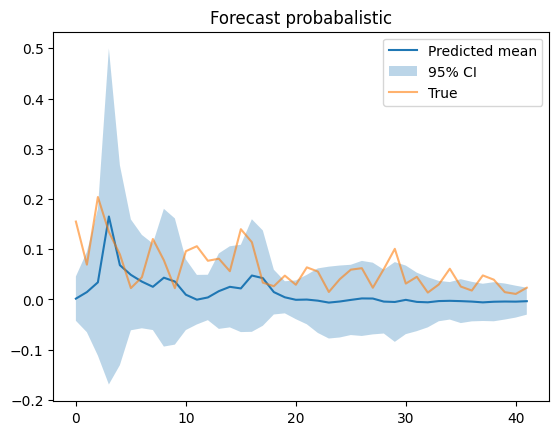

In [ ]:
# plt.plot(mu_pred, label='Predicted mean')
# plt.fill_between(range(len(mu_pred)),
#                  mu_pred - 1.96 * sigma_pred,
#                  mu_pred + 1.96 * sigma_pred,
#                  alpha=0.3, label='95% CI')
# plt.plot(y_lstm[:,0], label='True', alpha=0.6)
# plt.legend()
# plt.title("Forecast probabalistic")
# plt.show()

In [ ]:
def build_probabilistic_model_30days(timesteps, features):
    inputs = layers.Input(shape=(timesteps, features))

    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(inputs)
    x = layers.Conv1D(128, kernel_size=4, activation='relu', padding='causal')(x)
    x = layers.MaxPool1D()(x)
    x = layers.LSTM(256, return_sequences=True)(x)
    x = layers.LSTM(64)(x)

    x = layers.Dense(16, activation='relu')(x)
    

    mu = layers.Dense(1)(x)
    sigma = layers.Dense(1, activation='softplus')(x)  # softplus to ensure σ > 0

    outputs = layers.Concatenate()([mu, sigma])
    model = models.Model(inputs, outputs)
    return model

# Custom loss function for Gaussian NLL
def gaussian_nll(y_true, y_pred):
    mu = y_pred[:, 0]
    sigma = y_pred[:, 1] + 1e-6  # avoid log(0)
    return tf.reduce_mean(0.5 * tf.math.log(2 * np.pi * sigma**2) + (tf.squeeze(y_true) - mu)**2 / (2 * sigma**2))

In [227]:
model = build_probabilistic_model_30days(X_lstm.shape[1], X_lstm.shape[2])
model.compile(optimizer='adam', loss=gaussian_nll)
model.fit(X_lstm, y_lstm, epochs=100, batch_size=24, verbose=1, validation_data=[X_test_lstm, y_test_lstm])

Epoch 1/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: -1.9585 - val_loss: -2.9635
Epoch 2/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: -2.5382 - val_loss: -2.9852
Epoch 3/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: -3.1509 - val_loss: -3.8066
Epoch 4/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: -3.0087 - val_loss: -3.3420
Epoch 5/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: -3.3376 - val_loss: -3.9091
Epoch 6/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: -3.3879 - val_loss: -3.3827
Epoch 7/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: -3.4511 - val_loss: -3.3477
Epoch 8/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: -3.5388 - val_loss: -4.0363
Epoch 9/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: -3.5934 - val_loss: -3.5954
Epoch 10/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: -3.6433 - val_loss: -4.1162
Epoch 11/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: -2.9507 - val_loss: -3.9457
Epoch 12/100
555/55

In [228]:
yhat = model.predict(X_lstm)

417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [229]:
mu_pred = yhat[:, 0]
sigma_pred = yhat[:, 1]

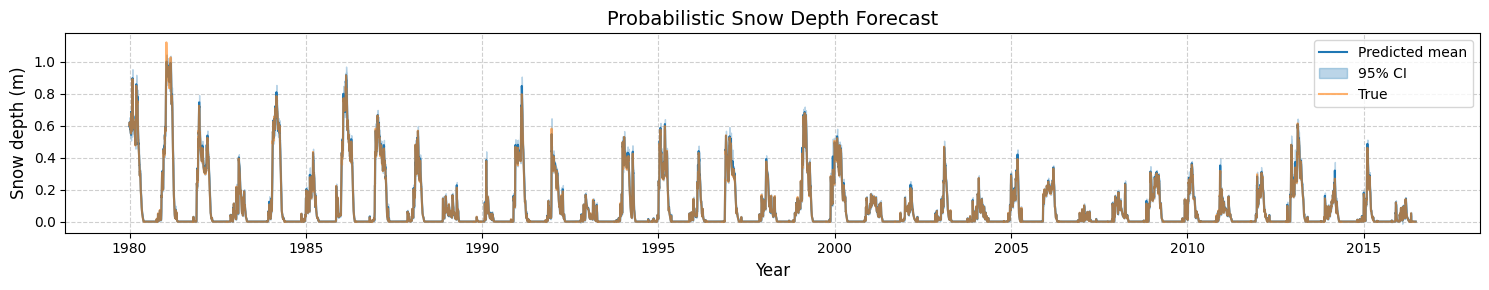

In [241]:
plt.figure(figsize=(15, 3))

# X-axis values: years since 1960
# years = np.arange(1960, 1960 + len(mu_pred))
months = np.arange(len(mu_pred))
start_year = 1980
years = start_year + months / 365

# Plot predicted mean
plt.plot(years, mu_pred, label='Predicted mean', color='C0')

# Fill 95% CI
plt.fill_between(
    years,
    mu_pred - 1.96 * sigma_pred,
    mu_pred + 1.96 * sigma_pred,
    alpha=0.3,
    color='C0',
    label='95% CI'
)

# Plot true values
plt.plot(years, y_lstm[:, 0], label='True', alpha=0.6, color='C1')

# Labels and title
plt.xlabel("Year", fontsize=12)
plt.ylabel("Snow depth (m)", fontsize=12)
plt.title("Probabilistic Snow Depth Forecast", fontsize=14)

# Legend and grid
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [242]:
yhat_test = model.predict(X_test_lstm)
mu_pred_test = yhat_test[:, 0]
sigma_test = yhat_test[:, 1]

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


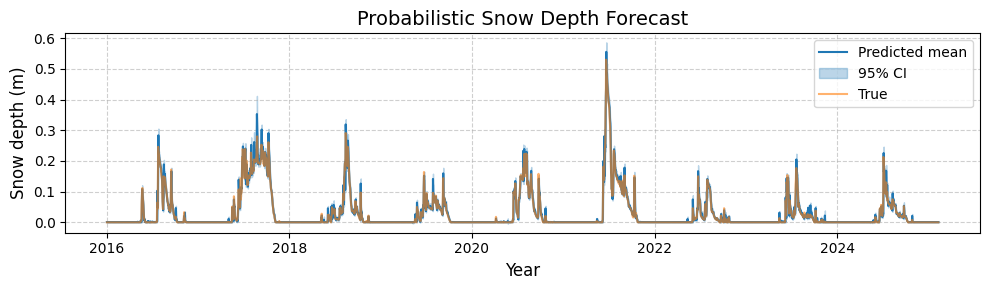

In [244]:
plt.figure(figsize=(10, 3))

# X-axis values: years since 1960
# years = np.arange(1960, 1960 + len(mu_pred))
months = np.arange(len(mu_pred_test))
start_year = 2016
years = start_year + months / 365

# Plot predicted mean
plt.plot(years, mu_pred_test, label='Predicted mean', color='C0')

# Fill 95% CI
plt.fill_between(
    years,
    mu_pred_test - 1.96 * sigma_test,
    mu_pred_test+ 1.96 * sigma_test,
    alpha=0.3,
    color='C0',
    label='95% CI'
)

# Plot true values
plt.plot(years, y_test_lstm[:,0], label='True', alpha=0.6, color='C1')

# Labels and title
plt.xlabel("Year", fontsize=12)
plt.ylabel("Snow depth (m)", fontsize=12)
plt.title("Probabilistic Snow Depth Forecast", fontsize=14)

# Legend and grid
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

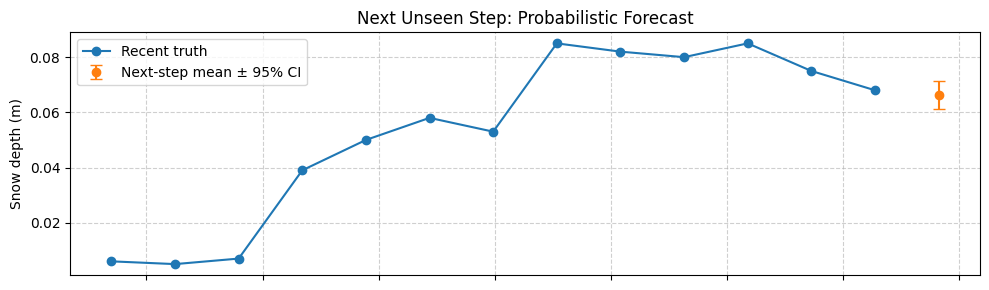

In [252]:
# Assume last observed time is years[-1], and your model gives next-step (t+1) params:
mu_next = mu_pred[-150]         # or your dedicated next-step output
sigma_next = sigma_pred[-150]

t_next = years[-150] + 1/365   # one month after last timestamp (adjust if your freq differs)

fig, ax = plt.subplots(figsize=(10, 3))

# Plot the recent history for context (last ~3 years)
window = 12   # months
ax.plot(years[-window-150:-149], y_lstm[-window-150:-149, 0], label='Recent truth', marker='o')

# Show the predictive distribution for t+1
ax.errorbar([t_next], [mu_next], yerr=[1.96 * sigma_next], fmt='o', capsize=4,
            label='Next-step mean ± 95% CI')

# ax.set_xlabel("Year")
ax.set_ylabel("Snow depth (m)")
ax.set_title("Next Unseen Step: Probabilistic Forecast")
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_xticklabels([])
ax.legend()
plt.tight_layout()
plt.show()

In [186]:
times = df['DATE']

In [187]:
times

0      1980-01-01
1      1980-01-04
2      1980-01-07
3      1980-01-10
4      1980-01-13
          ...    
5545   2025-07-18
5546   2025-07-21
5547   2025-07-24
5548   2025-07-27
5549   2025-07-30
Name: DATE, Length: 5550, dtype: datetime64[ns]

ValueError: x and y must have same first dimension, but have shapes (365,) and (0,)

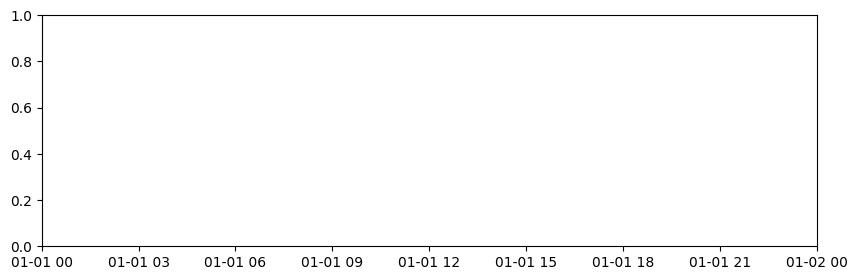

In [188]:
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Inputs:
# times: pd.DatetimeIndex aligned with y_lstm / predictions (3-day cadence)
times = df.set_index('DATE').index
# mu_pred, sigma_pred, y_lstm
# If you calibrated uncertainty, pick ONE:
crit = 1.96                      # vanilla
# crit = q * a_opt               # hybrid conformal (recommended)
# crit = 1.96 * a_hit            # parametric scale to hit 95%

step = pd.Timedelta(days=3)
t_next = times[-1] + step

# ~3 years of context: ~365*3 / 3 ≈ 365 points
window_steps = int(np.ceil(pd.Timedelta(days=365*3) / step))  # ≈ 365
start_idx = max(0, len(times) - window_steps)

mu_next    = mu_pred[-1]
sigma_next = sigma_pred[-1]

fig, ax = plt.subplots(figsize=(10, 3))

ax.plot(times[start_idx:], y_lstm[start_idx:, 0], label='Recent truth')

ax.errorbar([t_next], [mu_next],
            yerr=[crit * sigma_next],
            fmt='o', capsize=4,
            label=f'Next-step mean ± {int(100*(1-2*(1-0.975)))}% band')

ax.set_ylabel("Snow depth (m)")
ax.set_title("Next Unseen Step: Probabilistic Forecast (3-day cadence)")
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()

# nicer date ticks
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.tight_layout()
plt.show()


In [147]:
y_lstm.shape

(440, 1)

In [148]:
y_true_test = y_lstm[400:, 0]
mu_test = mu_pred[400:]
sig_test = sigma_pred[400:]

inside = (y_true_test >= mu_test - 1.96*sig_test) & (y_true_test <= mu_test + 1.96*sig_test)
coverage_95 = inside.mean()
print(f"Empirical 95% coverage: {coverage_95:.3f}")


Empirical 95% coverage: 1.000


In [149]:
z = (y_true_test - mu_test) / sig_test
print("std(z) =", np.std(z), "  mean(z) =", np.mean(z))

std(z) = 0.42403760978530686   mean(z) = 0.04824444412385871


In [150]:
from scipy.optimize import minimize
import numpy as np

y = y_true_test
mu = mu_test
s = sig_test

def nll(a):
    a = np.exp(a)   # enforce positivity
    var = (a*s)**2
    return 0.5*np.mean(np.log(2*np.pi*var) + (y-mu)**2/var)

res = minimize(nll, x0=[0.0])
a_opt = np.exp(res.x[0])
print("Optimal scale a:", a_opt)

sig_cal = a_opt * s
# New coverage:
inside = (y >= mu - 1.96*sig_cal) & (y <= mu + 1.96*sig_cal)
print("New 95% coverage:", inside.mean())


Optimal scale a: 0.42677327971566154
New 95% coverage: 0.925


In [ ]:
def coverage_at(a):
    lo = mu_test - 1.96 * a * sig_test
    hi = mu_test + 1.96 * a * sig_test
    return ((y_true_test >= lo) & (y_true_test <= hi)).mean()

lo_a, hi_a = a_opt, 2.5 * a_opt  # widen upper bound if needed
for _ in range(30):
    mid = 0.5 * (lo_a + hi_a)
    cov = coverage_at(mid)
    if cov < 0.95:
        lo_a = mid  # need wider intervals -> larger a
    else:
        hi_a = mid
a_hit = 0.5 * (lo_a + hi_a)
print("a for ~95% coverage:", a_hit, "coverage:", coverage_at(a_hit))

a for ~95% coverage: 0.4402989059522705 coverage: 0.95


In [ ]:
# Use a separate calibration set (recommended)
z_cal = np.abs((y_val - mu_val) / (a_opt * sig_val))
q = np.quantile(z_cal, 0.95)

# Apply on test
lo = mu_test - q * a_opt * sig_test
hi = mu_test + q * a_opt * sig_test
coverage = ((y_true_test >= lo) & (y_true_test <= hi)).mean()
print("Conformalized 95% coverage:", coverage)


In [ ]:
# Using hybrid conformal (recommended)
band = q * a_opt * sigma_pred  # or 1.96 * a_hit * sigma_pred for Option B

plt.figure(figsize=(11, 6))
plt.plot(years, mu_pred, label='Predicted mean')
plt.fill_between(years, mu_pred - band, mu_pred + band, alpha=0.25, label='Calibrated 95% band')
plt.plot(years, y_lstm[:,0], alpha=0.7, label='True')
plt.title(f"One‑Step Probabilistic Forecast — 95% coverage ≈ {coverage:.3f}")
plt.xlabel("Year"); plt.ylabel("Snow depth (m)")
plt.grid(True, linestyle='--', alpha=0.6); plt.legend(); plt.tight_layout(); plt.show()


In [123]:
import numpy as np

def forecast_next_n(model, seed_window, steps=5, target_idx=0, sample=False, rng=None):
    
    if rng is None:
        rng = np.random.default_rng()

    seq = np.array(seed_window, dtype=np.float32)
    mu_list, sigma_list = [], []

    for _ in range(steps):
        mu_sigma = model.predict(seq[None, ...], verbose=0)[0]  # -> [mu, sigma]
        mu, sigma = float(mu_sigma[0]), float(mu_sigma[1])
        mu_list.append(mu); sigma_list.append(sigma)

        next_target = mu if not sample else rng.normal(mu, sigma)
        next_frame = seq[-1].copy()
        next_frame[target_idx] = next_target

        # roll window
        seq = np.vstack([seq[1:], next_frame])

    # seed (except last row) + generated future
    traj = np.vstack([seed_window[:-1], seq[-steps:]])
    return np.array(mu_list), np.array(sigma_list), traj

In [124]:
seed = X_lstm[-1]
seed = seed.copy() 

In [125]:
X_lstm[-1].shape

(4, 25)

In [129]:
mu5, sigma5, traj5 = forecast_next_n(model, seed, steps=12, target_idx=0, sample=False)

In [130]:
mu5

array([-0.00085815, -0.0002409 ,  0.00108728,  0.00348728,  0.00348716,
        0.00349077,  0.00349137,  0.00349064,  0.00349067,  0.00349067,
        0.00349064,  0.00349064])

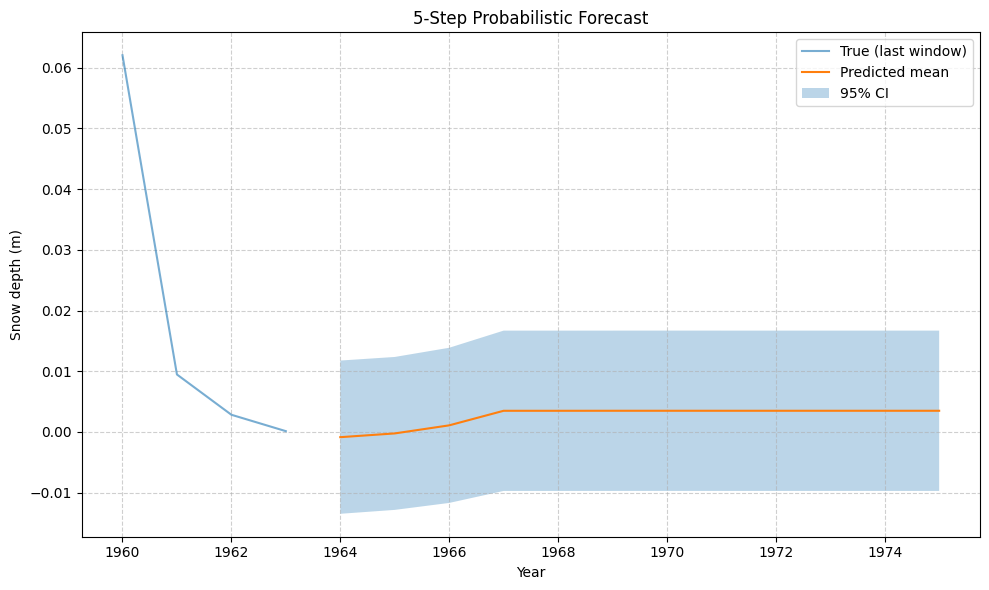

In [131]:
import matplotlib.pyplot as plt

T = seed.shape[0]
hist_y = y_lstm[-T:, 0]            # true values aligned with the seed window (adjust if needed)

years_hist = np.arange(1960, 1960 + T)
years_future = np.arange(years_hist[-1] + 1, years_hist[-1] + 1 + len(mu5))

plt.figure(figsize=(10,6))
plt.plot(years_hist, hist_y, label="True (last window)", alpha=0.6)
plt.plot(years_future, mu5, label="Predicted mean")
plt.fill_between(years_future, mu5 - 1.96*sigma5, mu5 + 1.96*sigma5, alpha=0.3, label="95% CI")
plt.xlabel("Year"); plt.ylabel("Snow depth (m)")
plt.title("5‑Step Probabilistic Forecast")
plt.grid(True, linestyle="--", alpha=0.6); plt.legend(); plt.tight_layout(); plt.show()


In [279]:
ytrue = y_test_lstm.ravel()

In [280]:
from sklearn.metrics import root_mean_squared_error

root_mean_squared_error(ytrue, mu_pred_test)

0.008307070579385647

In [281]:
import joblib

In [282]:
ndays = 1
model.save(f'model_{ndays}days.keras')
joblib.dump(scaler_y, f'scaler_y_{ndays}days.pkl')
joblib.dump(scaler_x, f'scaler_x_{ndays}days.pkl')

['scaler_x_1days.pkl']

In [54]:
joblib.dump(scaler_y, 'scaler_y_30days.pkl')

['scaler_y_30days.pkl']